<a href="https://colab.research.google.com/github/tylerb55/COMP530/blob/main/ResNetxMobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/tylerb55/COMP530.git

fatal: destination path 'COMP530' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import collections
import matplotlib.image as img
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import PIL.Image as Image

# **Split the train test and validation set**

In [3]:
def Train_Validation_Test_Set(directory_name):
  """a function to load the images in a large directory into a tensorflow dataset object
  the data is split 80:10:10 in training:validation:test. The dataset is shuffled before splitting
  and the images are formatted to 512x512 pixels and grayscale(one color channel and the values range from 0 to 255)"""
  dataset_train=tf.keras.preprocessing.image_dataset_from_directory('/content/COMP530/'+directory_name,
                                                                    labels='inferred',
                                                                    label_mode='int',
                                                                    class_names=['NormalCases','cancercases'],
                                                                    image_size=(512,512),
                                                                    shuffle=True,
                                                                    seed=305,
                                                                    validation_split=0.2,
                                                                    subset='training',
                                                                    batch_size=None
                                                                    )

  dataset_validation=tf.keras.preprocessing.image_dataset_from_directory('/content/COMP530/'+directory_name,
                                                                    labels='inferred',
                                                                    label_mode='int',
                                                                    class_names=['NormalCases','cancercases'],
                                                                    image_size=(512,512),
                                                                    shuffle=True,
                                                                    seed=305,
                                                                    validation_split=0.2,
                                                                    subset='validation',
                                                                    batch_size=None
                                                                    )
  
  dataset_test=tf.keras.preprocessing.image_dataset_from_directory('/content/COMP530/'+directory_name,
                                                                    labels='inferred',
                                                                    label_mode='int',
                                                                    class_names=['NormalCases','cancercases'],
                                                                    image_size=(512,512),
                                                                    shuffle=True,
                                                                    seed=305,
                                                                    validation_split=0.1,
                                                                    subset='validation',
                                                                    batch_size=None
                                                                    )
    
  dataset_validation=dataset_validation.take(dataset_test.__len__())

  return dataset_train,dataset_validation,dataset_test

In [4]:
def ResNetPreprocess(image,label):
  image = image/255.0
  # Resize images from 512x512 to 224x224
  image = tf.image.resize(image, (224,224))
  return image, label

In [5]:
def AlexNetPreprocess(image,label):
  image = image/255.0
  # Resize images from 512x512 to 224x224
  image = tf.image.resize(image, (227,227))
  return image, label

In [6]:
BATCH_SIZE=32

dataset_train,dataset_validation, dataset_test=Train_Validation_Test_Set("Dataset1")
dataset_train=dataset_train.map(AlexNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)
dataset_validation=dataset_validation.map(AlexNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)
dataset_test=dataset_test.map(AlexNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)

AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_validation = dataset_validation.cache().prefetch(buffer_size=AUTOTUNE)

Found 1097 files belonging to 2 classes.
Using 878 files for training.
Found 1097 files belonging to 2 classes.
Using 219 files for validation.
Found 1097 files belonging to 2 classes.
Using 109 files for validation.


In [7]:
BATCH_SIZE=32

dataset_train,dataset_validation, dataset_test=Train_Validation_Test_Set("Dataset1")
dataset_train=dataset_train.map(ResNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)
dataset_validation=dataset_validation.map(ResNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)
dataset_test=dataset_test.map(ResNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)

AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_validation = dataset_validation.cache().prefetch(buffer_size=AUTOTUNE)

Found 1097 files belonging to 2 classes.
Using 878 files for training.
Found 1097 files belonging to 2 classes.
Using 219 files for validation.
Found 1097 files belonging to 2 classes.
Using 109 files for validation.


# **mobilenet v2**

In [8]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

num_classes = 1

mobilenet = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
mobilenet.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['acc'])

NUM_EPOCHS = 30

history = mobilenet.fit(dataset_train,
                    validation_data=dataset_validation,
                    epochs=NUM_EPOCHS)

Epoch 1/30
27/27 [==============================] - 25s 124ms/step - loss: 5.5045 - acc: 0.5197 - val_loss: 1.7172 - val_acc: 0.7812
Epoch 2/30
27/27 [==============================] - 1s 29ms/step - loss: 1.6858 - acc: 0.7812 - val_loss: 1.2613 - val_acc: 0.8021
Epoch 3/30
27/27 [==============================] - 1s 28ms/step - loss: 1.5074 - acc: 0.7627 - val_loss: 1.6514 - val_acc: 0.7083
Epoch 4/30
27/27 [==============================] - 1s 28ms/step - loss: 1.4366 - acc: 0.7882 - val_loss: 1.7260 - val_acc: 0.8125
Epoch 5/30
27/27 [==============================] - 1s 28ms/step - loss: 1.3157 - acc: 0.8310 - val_loss: 1.2079 - val_acc: 0.7917
Epoch 6/30
27/27 [==============================] - 1s 28ms/step - loss: 1.1652 - acc: 0.8368 - val_loss: 1.1919 - val_acc: 0.8021
Epoch 7/30
27/27 [==============================] - 1s 28ms/step - loss: 1.0864 - acc: 0.8438 - val_loss: 1.2684 - val_acc: 0.8125
Epoch 8/30
27/27 [==============================] - 1s 28ms/step - loss: 1.1343 -

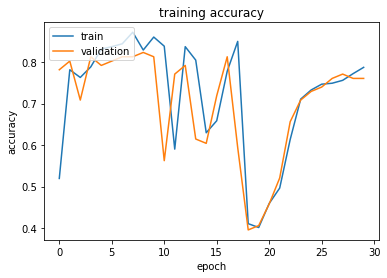

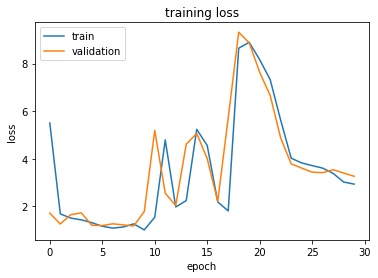

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Resnet 50**

In [11]:
resnet = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
feature_extractor_model = resnet

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

num_classes = 1

resnet50 = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

resnet50.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


In [12]:
resnet50.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['acc'])

NUM_EPOCHS = 10

history = resnet50.fit(dataset_train,
                    validation_data=dataset_validation,
                    epochs=NUM_EPOCHS)

Epoch 1/10
27/27 [==============================] - 10s 98ms/step - loss: 3.0206 - acc: 0.6840 - val_loss: 2.7272 - val_acc: 0.7812
Epoch 2/10
27/27 [==============================] - 2s 66ms/step - loss: 2.0654 - acc: 0.7593 - val_loss: 1.8332 - val_acc: 0.7812
Epoch 3/10
27/27 [==============================] - 2s 65ms/step - loss: 1.9715 - acc: 0.8056 - val_loss: 2.6704 - val_acc: 0.7708
Epoch 4/10
27/27 [==============================] - 2s 66ms/step - loss: 1.6054 - acc: 0.8576 - val_loss: 1.8816 - val_acc: 0.8021
Epoch 5/10
27/27 [==============================] - 2s 66ms/step - loss: 3.2365 - acc: 0.7465 - val_loss: 2.2149 - val_acc: 0.7917
Epoch 6/10
27/27 [==============================] - 2s 65ms/step - loss: 1.4260 - acc: 0.8634 - val_loss: 2.0505 - val_acc: 0.8021
Epoch 7/10
27/27 [==============================] - 2s 65ms/step - loss: 1.5124 - acc: 0.8727 - val_loss: 1.8557 - val_acc: 0.8333
Epoch 8/10
27/27 [==============================] - 2s 65ms/step - loss: 1.4587 - 

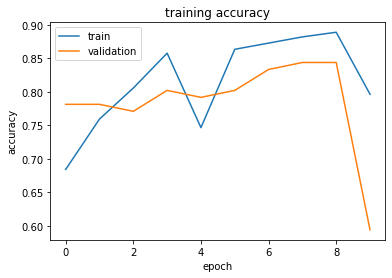

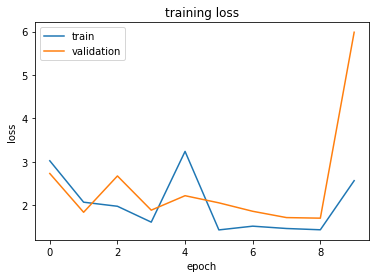

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Alexnet**

Test the model on the test set and evaluate performance

In [14]:
resnet50.evaluate(dataset_test)

3/3 [==============================] - 1s 62ms/step - loss: 5.2430 - acc: 0.6146


[5.2430338859558105, 0.6145833134651184]

In [15]:
mobilenet.evaluate(dataset_test)

3/3 [==============================] - 1s 43ms/step - loss: 2.6697 - acc: 0.8125


[2.6696579456329346, 0.8125]